In [248]:
# !pip install ffmpeg
# !pip install SpeechRecognition pydub
# !pip install Katna
# !pip install pytesseract
# !pip install --upgrade azure-cognitiveservices-vision-face
import os
import subprocess
import sys
import numpy as np
# speech recognition
import speech_recognition as sr
from pydub import AudioSegment
from pydub.silence import split_on_silence
import shutil

# extract key frame
import cv2
from Katna.video import Video
from Katna.writer import KeyFrameDiskWriter

# text ocr
import pytesseract

# face analysis
import asyncio
import io
import glob
import time
import uuid
import requests
from urllib.parse import urlparse
from io import BytesIO
# To install this module, run:
# python -m pip install Pillow
from PIL import Image, ImageDraw
from azure.cognitiveservices.vision.face import FaceClient
from msrest.authentication import CognitiveServicesCredentials
from azure.cognitiveservices.vision.face.models import TrainingStatusType, Person, QualityForRecognition
import time

# nlp analysis
from nltk.corpus import stopwords
from nltk import word_tokenize
import json
import pandas as pd
import matplotlib.pyplot as plt
import string
from wordcloud import WordCloud, STOPWORDS

project_dir = "/Users/heisenbergliu/Desktop/Spring-2022/DS/project"
data_scraped_dir = project_dir + '/data/scrape' 
rep_video_dir = data_scraped_dir+"/#republican_927"
dem_video_dir = data_scraped_dir+"/#democrat_940"
rep_audio_dir = data_scraped_dir+"/#republican_927_audio"
dem_audio_dir = data_scraped_dir+"/#democrat_940_audio"
rep_text_from_audio_dir = data_scraped_dir+"/#republican_927_text"
dem_text_from_audio_dir = data_scraped_dir+"/#democrat_940_text"
rep_key_frames_dir = data_scraped_dir+"/#republican_927_key_frames"
dem_key_frames_dir = data_scraped_dir+"/#democrat_940_key_frames"
rep_text_from_video_dir = data_scraped_dir+"/#republican_927_text_video"
dem_text_from_video_dir = data_scraped_dir+"/#democrat_940_text_video"

In [ ]:
# tools for extracting audio from video

def convert_video_to_audio_ffmpeg(video_file, output_dir,output_ext="wav"):
    filename, ext = os.path.splitext(video_file)
    try:
        slash_index = filename.rindex('/')
        filename = filename[slash_index+1:]
    except:
        pass
    output_file = output_dir+'/'+filename +'.'+output_ext
    print(output_file)
    command = "ffmpeg -i {input_file} -ab 160k -ac 2 -ar 44100 -vn {output_file}".format(input_file = video_file, output_file = output_file)
    subprocess.call(command,shell = True) 
    
def video_to_audio(input_dir,output_dir):
    for filename in os.listdir(input_dir):
        f = os.path.join(input_dir, filename)
        # checking if it is a file
        if os.path.isfile(f):
            convert_video_to_audio_ffmpeg(f,output_dir)

# extract audio from republican videos
video_to_audio(rep_video_dir,rep_audio_dir)

# extract audio from democrat videos
video_to_audio(dem_video_dir,dem_audio_dir)

In [2]:
# transfer audio to text

audio_recongnizer = sr.Recognizer() 
def convert_audio_to_text(audio_file):
    with sr.AudioFile(audio_file) as source:
        # listen for the data (load audio to memory)
        audio_data = audio_recongnizer.record(source)
        # recognize (convert from speech to text)
        text = audio_recongnizer.recognize_google(audio_data)
    
def convert_audio_to_text_big_file(audio_file):
    # open the audio file using pydub
    sound = AudioSegment.from_wav(audio_file)  
    # split audio sound where silence is 700 miliseconds or more and get chunks
    chunks = split_on_silence(sound,
        # experiment with this value for your target audio file
        min_silence_len = 700,
        # adjust this per requirement
        silence_thresh = sound.dBFS-14,
        # keep the silence for 1 second, adjustable as well
        keep_silence=500,
    )
    
    slash_idx = audio_file.rindex('/')
    filename =  audio_file[slash_idx:-4]
    folder_name = project_dir+"/audio-chunks"+filename
    os.mkdir(folder_name)
    # create a directory to store the audio chunks
#     if not os.path.isdir(folder_name):
#         os.mkdir(folder_name)
    whole_text = ""
    # process each chunk 
    for i, audio_chunk in enumerate(chunks, start=1):
        # export audio chunk and save it in
        # the `folder_name` directory.
        chunk_filename = os.path.join(folder_name, f"chunk{i}.wav")
        audio_chunk.export(chunk_filename, format="wav")
        # recognize the chunk
        with sr.AudioFile(chunk_filename) as source:
            audio_listened = audio_recongnizer.record(source)
            # try converting it to text
            try:
                text = audio_recongnizer.recognize_google(audio_listened)
            except sr.UnknownValueError as e:
                pass
            else:
                text = f"{text.capitalize()}. "
                whole_text += text
    # return the text for all chunks detected
    return whole_text

def get_existed_files(directory):
    files_set = set()
    for filename in os.listdir(directory):
        files_set.add(filename)
    return files_set
    
def audio_to_text(input_dir,output_dir):
    existed_file = get_existed_files(output_dir)
    folder_name = project_dir+"/audio-chunks"
    # create a directory to store the audio chunks
    if not os.path.isdir(folder_name):
        os.mkdir(folder_name)
    for filename in os.listdir(input_dir):
        f = os.path.join(input_dir, filename)
        # #  checking if it is a file
#         if os.path.isfile(f):
        try:
            filename = filename[:-4]+'.txt'
            if filename in existed_file:
                print("existed: "+filename)
                continue
            text = convert_audio_to_text_big_file(f)
            output_file = output_dir+'/'+ filename
            print('work on '+output_file)
            with open(output_file, 'w') as text_file:
                text_file.write(text)
        except Exception as e: 
            print(e)
            print('failed: '+filename)
        else:
            print('success: '+filename)        
    shutil.rmtree(project_dir+'/audio-chunks')  

In [127]:
# republican audio to text
audio_to_text(rep_audio_dir,rep_text_from_audio_dir)

# # democrat audio to text
audio_to_text(dem_audio_dir,dem_text_from_audio_dir)

work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/7052410024886308101.txt
success: 7052410024886308101.txt
work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/6847565214867541253.txt
success: 6847565214867541253.txt
work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/6878143545023286530.txt
success: 6878143545023286530.txt
work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/6933270023817514245.txt
success: 6933270023817514245.txt
work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/7070521347562081541.txt
success: 7070521347562081541.txt
work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/6922242221810994437.txt
success: 6922242221810994437.txt
work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/6961957571318107398.t

work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/6995956796015873286.txt
success: 6995956796015873286.txt
work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/6890944452429499653.txt
success: 6890944452429499653.txt
work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/6924018006444068101.txt
success: 6924018006444068101.txt
work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/6997512273791110405.txt
success: 6997512273791110405.txt
work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/6843056700006731013.txt
success: 6843056700006731013.txt
work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/6884009467181092102.txt
success: 6884009467181092102.txt
work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/7033795104775228678.t

work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/7071379868356955438.txt
success: 7071379868356955438.txt
work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/7023048223199612166.txt
success: 7023048223199612166.txt
work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/6900597078775385350.txt
success: 6900597078775385350.txt
work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/6998581162033630470.txt
success: 6998581162033630470.txt
work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/6833504510112025861.txt
success: 6833504510112025861.txt
work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/6860414477184011525.txt
success: 6860414477184011525.txt
work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/6891068212650183941.t

work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/7051683046592056623.txt
success: 7051683046592056623.txt
work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/7013003485100739845.txt
success: 7013003485100739845.txt
work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/7025812560075279662.txt
success: 7025812560075279662.txt
work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/6946643328553192709.txt
success: 6946643328553192709.txt
work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/6987394582405303558.txt
success: 6987394582405303558.txt
work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/6986005732600630533.txt
success: 6986005732600630533.txt
work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/6883548031812193542.t

work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/6837699911643827462.txt
success: 6837699911643827462.txt
work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/7007106950416665862.txt
success: 7007106950416665862.txt
work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/6861336488534183174.txt
success: 6861336488534183174.txt
work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/6966263845065198854.txt
success: 6966263845065198854.txt
work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/6966301864186973446.txt
success: 6966301864186973446.txt
work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/6795710737135176966.txt
success: 6795710737135176966.txt
work on /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_text/6887700465543335173.t

KeyboardInterrupt: 

In [134]:
# extract key frames from videos
def get_video_duration(filename):
    result = subprocess.run(["ffprobe", "-v", "error", "-show_entries",
                             "format=duration", "-of",
                             "default=noprint_wrappers=1:nokey=1", filename],
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT)
    return float(result.stdout)

def extract_key_frame(file_path, output_dir):
    filename = os.path.basename(file_path)[:-4]
    vd = Video()
    no_of_frames_to_returned  = int(get_video_duration(file_path)/2)
    output_path = output_dir+'/'+filename
    if not os.path.isdir(output_path):
        os.mkdir(output_path)
    diskwriter = KeyFrameDiskWriter(location=output_path)
    vd.extract_video_keyframes(
     no_of_frames=10, file_path=file_path,
     writer=diskwriter)

def extract_key_frames_from_dir(input_dir, output_dir):
    existed_files = get_existed_files(output_dir)
    for filename in os.listdir(input_dir):
        if filename[:-4] in existed_files:
            print('existed '+filename)
        file_path = os.path.join(input_dir, filename)
        try:
            extract_key_frame(file_path, output_dir)
        except Exception as e:
            print(e)
            print('fail '+file_path)
        else:
            print('success '+file_path)
        
# extract key frames from videos about republican
extract_key_frames_from_dir(rep_video_dir,rep_key_frames_dir)

# extract key frames from videos about democrat
extract_key_frames_from_dir(dem_video_dir,dem_key_frames_dir)

Completed processing for :  /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/6972308729719033094.mp4
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/6972308729719033094.mp4
Completed processing for :  /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/6944766124508728581.mp4
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/6944766124508728581.mp4
Completed processing for :  /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/7065076904814005510.mp4
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/7065076904814005510.mp4
Completed processing for :  /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/6997043576492412165.mp4
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/6997043576492412165.mp4
Completed processing for :  /Users/heise

Completed processing for :  /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/6915915969609207041.mp4
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/6915915969609207041.mp4
Completed processing for :  /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/6895919836631747845.mp4
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/6895919836631747845.mp4
Completed processing for :  /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/6877959099108183301.mp4
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/6877959099108183301.mp4
Completed processing for :  /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/7032876225022397701.mp4
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/7032876225022397701.mp4
Completed processing for :  /Users/heise

Completed processing for :  /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/6908750687006444806.mp4
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/6908750687006444806.mp4
Completed processing for :  /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/6854309907978587398.mp4
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/6854309907978587398.mp4
Completed processing for :  /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/6792102548166724870.mp4
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/6792102548166724870.mp4
Completed processing for :  /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/6969615913993686277.mp4
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/6969615913993686277.mp4
Completed processing for :  /Users/heise

Completed processing for :  /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/6857669003058482437.mp4
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/6857669003058482437.mp4
Completed processing for :  /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/6882158819225439494.mp4
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/6882158819225439494.mp4
Completed processing for :  /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/6842894216062913797.mp4
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/6842894216062913797.mp4
Completed processing for :  /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/6874232567197879557.mp4
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/6874232567197879557.mp4
Completed processing for :  /Users/heise

Completed processing for :  /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/6915102545916480774.mp4
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/6915102545916480774.mp4
Completed processing for :  /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/6960639661739953414.mp4
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/6960639661739953414.mp4
Completed processing for :  /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/7035346960487894278.mp4
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/7035346960487894278.mp4
Completed processing for :  /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/6876232866880048390.mp4
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940/6876232866880048390.mp4
Completed processing for :  /Users/heise

Process SpawnPoolWorker-5151:
Process SpawnPoolWorker-5152:
Process SpawnPoolWorker-5146:
Process SpawnPoolWorker-5150:
Process SpawnPoolWorker-5147:
Process SpawnPoolWorker-5149:
Process SpawnPoolWorker-5148:


KeyboardInterrupt: 

In [135]:
# extract information from key frames

def extract_text_from_frames(frame_dir, output_dir):
    text_set = set()
    for frame_name in os.listdir(frame_dir):
        frame_path = os.path.join(frame_dir, frame_name)
        cur_text = pytesseract.image_to_string(frame_path)
        text_set.add(cur_text)
    content = '. '.join(text_set)
    file_path = output_dir+'/'+os.path.basename(frame_dir)+'.txt'
    with open(file_path, 'w') as text_file:
        text_file.write(content) 
    
def extract_text_from_video(input_dir,output_dir):
    for filename in os.listdir(input_dir):
        file_path = os.path.join(input_dir, filename)
        try:
            extract_text_from_frames(file_path, output_dir)
        except Exception as e:
            print(e)
            print('fail '+file_path)
        else:
            print('success '+file_path)

# use ocr to extract text from videos
# extract_text_from_video(rep_key_frames_dir,rep_text_from_video_dir)

extract_text_from_video(dem_key_frames_dir,dem_text_from_video_dir)

success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6930720398254411013
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/7047174712279043333
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6854542328753851654
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6890759551730109701
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6953670830828031238
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6897389273197071621
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6980482300450573574
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6997882647166913798
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data

success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6882826105242406149
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6992701071353236742
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6944766124508728581
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6908750687006444806
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/7012392487415205125
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6859769165885099269
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6960333798504402182
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6792102548166724870
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data

success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6842894216062913797
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/7035346960487894278
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/7056969118435560751
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6877587251593891078
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6836795085993086213
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/7017317905306029318
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6957408074751560965
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6895919836631747845
success /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data

In [144]:
# extract face information
# key 1a467fe7aaa140e58e2bc009ee7e2884
FACE_KEY = "1a467fe7aaa140e58e2bc009ee7e2884"
FACE_ENDPOINT = 'https://changlazure.cognitiveservices.azure.com/'

# Create an authenticated FaceClient.
face_client = FaceClient(FACE_ENDPOINT, CognitiveServicesCredentials(FACE_KEY))

def extract_face_info(image_path):
    info = []
    time.sleep(3) # avoid rate limiter of Azure
    detected_faces = face_client.face.detect_with_stream(
        open(image_path, 'rb'),
        detection_model='detection_01',
        return_face_attributes = [
            'age',  
            'gender',
            'smile',
            'emotion',
        ]
    )
    if not detected_faces:
        print('No face detected from image {}'.format(image_path))
        return info
    emo_list = ['anger','contempt','disgust','fear','happiness','neutral','sadness','surprise']
    def get_emotion(emo_dict):
        cur_emo, max_score = '',0
        for emo in emo_list:
            score = emo_dict[emo]
            if score > max_score:
                max_score = score
                cur_emo = emo
        return cur_emo

    for face in detected_faces:
        obj = {
            'id':face.face_id,
            'age':face.face_attributes.age,
            'gender' : face.face_attributes.gender.__dict__['_value_'],
            'smile':face.face_attributes.smile,
            'emotion':get_emotion(face.face_attributes.emotion.__dict__)
        }
        info.append(obj)
    return info

def extract_face_from_frames(frame_dir):
    face_list = []
    id_list = []
    for frame in os.listdir(frame_dir):
        frame_path = os.path.join(frame_dir, frame)
        infos = extract_face_info(frame_path)
#         face_list.extend(infos)
#         id_list.extend(list(map(lambda x:x['id'],infos)))
        if not id_list:
            face_list.extend(infos)
            id_list.extend(list(map(lambda x:x['id'],infos)))
            continue
        for info in infos:
            time.sleep(3) # avoid rate limiter of Azure
            similar_faces = face_client.face.find_similar(face_id=info['id'], face_ids=id_list)
            if not similar_faces:
                print('add '+info['id'])
                face_list.append(info)
                id_list.append(info['id'])
            else:
                print('exist '+info['id'])
    return face_list

def get_all_face_info(input_dir, limit = None):
#     rep_key_frames_dir
    all_info = []
    count = 0
    for frame_dir_name in os.listdir(input_dir):
        if limit and limit <= count:
            break
        count += 1
        frame_dir_path = os.path.join(input_dir, frame_dir_name)
        print('work on '+frame_dir_name)
        try:
            all_info.extend(extract_face_from_frames(frame_dir_path))
        except Exception as e:
            print(e)
            print('failed '+frame_dir_name)
    return all_info

# face information collection of republican
def store_face_inf(frame_dir, target_file):
    face_info = get_all_face_info(frame_dir, 100)
    json_str = json.dumps(face_info)
    with open(target_file, 'w') as file:
        file.write(json_str)

rep_face_info_file = data_scraped_dir+'/rep_info.txt'
dem_face_info_file = data_scraped_dir+'/dem_info.txt'

store_face_inf(rep_key_frames_dir,rep_face_info_file)
store_face_inf(dem_key_frames_dir,dem_face_info_file)

work on 6930720398254411013
work on 7047174712279043333
No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/7047174712279043333/7047174712279043333_2.jpeg
No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/7047174712279043333/7047174712279043333_4.jpeg
No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/7047174712279043333/7047174712279043333_8.jpeg
No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/7047174712279043333/7047174712279043333_5.jpeg
No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/7047174712279043333/7047174712279043333_6.jpeg
No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/7047174

No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6882158819225439494/6882158819225439494_5.jpeg
No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6882158819225439494/6882158819225439494_9.jpeg
No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6882158819225439494/6882158819225439494_8.jpeg
No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6882158819225439494/6882158819225439494_4.jpeg
work on 6968100607638998278
work on 6839875042025721093
No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6839875042025721093/6839875042025721093_1.jpeg
No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6839875

No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6866137137016737030/6866137137016737030_4.jpeg
No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6866137137016737030/6866137137016737030_2.jpeg
work on 6873611607663004934
No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6873611607663004934/6873611607663004934_0.jpeg
No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6873611607663004934/6873611607663004934_7.jpeg
No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6873611607663004934/6873611607663004934_6.jpeg
No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6873611607663004934/687361160766300

No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6904096880737766661/6904096880737766661_8.jpeg
work on 6903283116824169734
No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6903283116824169734/6903283116824169734_6.jpeg
work on 6896943530384624902
No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6896943530384624902/6896943530384624902_1.jpeg
No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6896943530384624902/6896943530384624902_0.jpeg
work on 7000178312198769926
work on 6982224122533268742
No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6982224122533268742/6982224122533268742_6.jpeg
work on 6911494780832713990
No face detected from image /Users/heise

No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6992701071353236742/6992701071353236742_5.jpeg
No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6992701071353236742/6992701071353236742_9.jpeg
work on 6944766124508728581
No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6944766124508728581/6944766124508728581_6.jpeg
No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6944766124508728581/6944766124508728581_2.jpeg
No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6944766124508728581/6944766124508728581_3.jpeg
work on 6908750687006444806
No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6908750

No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6818928336572665093/6818928336572665093_6.jpeg
work on 6951033072401779974
No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/6951033072401779974/6951033072401779974_6.jpeg
work on 7031989754506022190
No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/7031989754506022190/7031989754506022190_6.jpeg
No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/7031989754506022190/7031989754506022190_4.jpeg
No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#democrat_940_key_frames/7031989754506022190/7031989754506022190_8.jpeg
work on 7014611235572370694
No face detected from image /Users/heisenbergliu/Desktop/Spring-2022/DS/project/data/scrape/#dem

In [228]:
# analysis video detail info

rep_video_detail = data_scraped_dir + '/#republican_103/republican_1650568413878.csv'
dem_video_detail = data_scraped_dir + '/#democrat_103/democrat_1650570477838.csv'

rep_detail = pd.read_csv(rep_video_detail) 
dem_detail = pd.read_csv(dem_video_detail)

def get_sum(pd_obj, columns):
    res = {}
    for c in columns:
        res[c] = pd_obj[c].sum()
    return res

def get_discinct_users(pd_obj):
    return pd_obj['authorMeta.id'].drop_duplicates().shape

# print(get_sum(rep_detail, ['diggCount', 'shareCount', 'playCount','commentCount']))
# print(get_sum(dem_detail, ['diggCount', 'shareCount', 'playCount','commentCount']))
# print(get_discinct_users(rep_detail))
# print(get_discinct_users(dem_detail))

def get_top5_hashtag(pd_obj):
    hash_list = pd_obj['hashtags']
    count = {}
    for hashtags in hash_list:
        cur_hash = json.loads(hashtags)
        for h in cur_hash:
            hash_val = h['name']
            count[hash_val] = count.get(hash_val,0)+1
    hash_count = list(count.items())
    hash_count.sort(key = lambda x:x[1],reverse = True)
    return hash_count[:21]

print(get_top5_hashtag(rep_detail))
print(get_top5_hashtag(dem_detail))
# res = json.loads(rep_detail['hashtags'].iloc[0])
# Index(['id', 'secretID', 'text', 'createTime', 'authorMeta.id',
#        'authorMeta.secUid', 'authorMeta.name', 'authorMeta.nickName',
#        'authorMeta.verified', 'authorMeta.signature', 'authorMeta.avatar',
#        'authorMeta.following', 'authorMeta.fans', 'authorMeta.heart',
#        'authorMeta.video', 'authorMeta.digg', 'musicMeta.musicId',
#        'musicMeta.musicName', 'musicMeta.musicAuthor',
#        'musicMeta.musicOriginal', 'musicMeta.musicAlbum', 'musicMeta.playUrl',
#        'musicMeta.coverThumb', 'musicMeta.coverMedium', 'musicMeta.coverLarge',
#        'musicMeta.duration', 'covers.default', 'covers.origin',
#        'covers.dynamic', 'webVideoUrl', 'videoUrl', 'videoUrlNoWaterMark',
#        'videoApiUrlNoWaterMark', 'videoMeta.height', 'videoMeta.width',
#        'videoMeta.duration', 'diggCount', 'shareCount', 'playCount',
#        'commentCount', 'downloaded', 'mentions', 'hashtags', 'effectStickers'],
#       dtype='object')


[('republican', 100), ('democrat', 52), ('fyp', 47), ('trump', 40), ('conservative', 34), ('politics', 32), ('liberal', 32), ('foryou', 26), ('biden', 21), ('election', 15), ('foryoupage', 14), ('usa', 13), ('biden2020', 12), ('trump2020', 11), ('viral', 10), ('trump2024', 9), ('america', 8), ('fypシ', 8), ('progressive', 8), ('stitch', 7), ('blm', 7)]
[('democrat', 100), ('republican', 57), ('fyp', 46), ('politics', 42), ('liberal', 42), ('biden2020', 24), ('biden', 21), ('trump', 21), ('foryou', 19), ('leftist', 18), ('conservative', 18), ('foryoupage', 16), ('blm', 11), ('fypシ', 9), ('feminism', 9), ('usa', 8), ('trump2020', 8), ('women', 7), ('greenscreen', 7), ('viral', 6), ('greenscreenvideo', 6)]


In [197]:
# analyze face info
def extract_face_info(json_file):
    with open(json_file,'rb') as file:
        info = json.loads(file.read())
    return info

# 166 vs 152
rep_face_info = extract_face_info(rep_face_info_file)
dem_face_info = extract_face_info(dem_face_info_file)

def cal_gender(face_info):
    male_cnt = 0
    for inf in face_info:
        if inf['gender'] == 'male':
            male_cnt += 1
    return male_cnt/5, (len(face_info) - male_cnt)/5

# rep ave 33.48803191489362
# dem ave 32.676584734799484
def get_age(face_info):
    ages = []
    for inf in face_info:
        ages.append(inf['age'])
    print(len(ages))
    range = (0, 100)
    bins = 20
    # plotting a histogram
    plt.hist(ages, bins, range, color = 'green',
            histtype = 'bar', rwidth = 0.8)

    # x-axis label
    plt.xlabel('age')
    # frequency label
    plt.ylabel('No. of people')
    # plot title
    plt.title('Democrat users age range')

    # function to show the plot
    plt.show()

def get_emotion_count(face_info):
    emo = {}
    for inf in face_info:
        cur_emo = inf['emotion']
        emo[cur_emo] = emo.get(cur_emo,0)+1
    tot = len(face_info)
    for k,_ in emo.items():
        emo[k] /= tot
    return emo

def get_ave_smile(face_info):
    sm = 0
    for inf in face_info:
        sm += inf['smile']
    return sm/len(face_info)

print(get_ave_smile(rep_face_info))
print(get_ave_smile(dem_face_info))
# print(get_age(rep_face_info))
# print(get_age(dem_face_info))

0.3065744680851065
0.26517852522639096


[('trump', 58), ('republicans', 30), ('voted', 25), ('years', 23), ('people', 21), ('state', 21), ('one', 19), ('every', 18), ('pm', 18), ('get', 16), ('york', 16), ('income', 16), ('city', 16), ('vote', 15), ('teen', 14), ('donald', 14), ('ale', 13), ('would', 13), ('time', 13), ('president', 13), ('instead', 12), ('wear', 12), ('election', 12), ('mel', 11), ('racist', 11), ('biden', 11), ('take', 11), ('week', 11), ('steve', 11), ('party', 11), ('episode', 11), ('men', 11), ('show', 10), ('supporters', 10), ('oh', 10), ('foryou', 10), ('fyp', 10), ('guy', 10), ('ben', 10), ('college', 10), ('graduated', 10), ('act', 10), ('teeks', 10), ('giving', 10), ('od', 9), ('st', 9), ('ee', 9), ('co', 9), ('person', 9), ('got', 9), ('home', 9)]


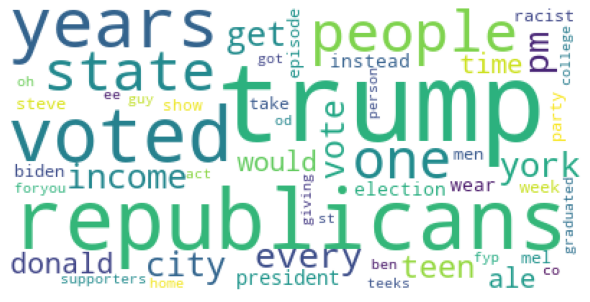

In [258]:
# analyze text from audio and video

stop_words = set(stopwords.words('english'))

remove_words = set(['ot','ob','tiktok', 'like', ])

def process_text_file(file_path):
    with open(file_path, 'rb') as file:
        text = str(file.read())
    res = []
    for tok in word_tokenize(text):
        if len(tok)<=1:
            continue
        if tok.lower() in stop_words:
            continue
        if tok.lower() in remove_words:
            continue
        if tok.isnumeric():
            continue
        contain_punc = False
        for punc in string.punctuation:
            if punc in tok:
                contain_punc = True
                break
        if contain_punc:
            continue
        res.append(tok.lower())
    return res
    
def get_N_frequent_words(text_dir, limit = None):
    word_list = []
    for filename in os.listdir(text_dir):
        file_path = os.path.join(text_dir, filename)
        word_list.extend(process_text_file(file_path))
    word_count = {}
    for w in word_list:
        word_count[w] = word_count.get(w,0)+1
    res = list(word_count.items())
    res.sort(key = lambda x:x[1],reverse = True)
    if limit:
        res = res[:limit+1]
    return res  

def generate_cloud(text_dir, limit = None):
    text_freq_list = get_N_frequent_words(text_dir, limit = limit)
    print(text_freq_list)
    freq = {}
    for t,f in text_freq_list:
        freq[t] = f
    wordcloud = WordCloud(collocations = False,
                background_color ='white')
    wordcloud.generate_from_frequencies(frequencies=freq)                  
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()
    

# print(get_N_frequent_words(rep_text_from_audio_dir,40)) # 926
# print(get_N_frequent_words(dem_text_from_audio_dir,40)) # 227
# print(get_N_frequent_words(rep_text_from_video_dir,40)) # 166
# print(get_N_frequent_words(dem_text_from_video_dir,40)) # 152

# generate_cloud(rep_text_from_audio_dir,50)

# generate_cloud(dem_text_from_audio_dir,50)
# generate_cloud(rep_text_from_video_dir,50)
generate_cloud(dem_text_from_video_dir,50)